# XRDスペクトル算出プログラムの実装
## 仕様
- 最も低い対称性（原子種、原子位置、格子定数のみ）を入力（生のPOSCAR形式？）
- hklを生成
- 原子位置とhklから結晶構造因子を算出
- 2θを横軸としたスペクトルを算出

原子位置・格子定数はすべて微分可能にする

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fftn, ifftn
from matplotlib.colors import Normalize
import os
import sys
import random

In [2]:
from jax import random,jit,vmap
import jax.numpy as jnp

In [3]:
#原子散乱因子のインポート
import json
with open("atomic_scattering_params.json") as f:
    SCATTERING_FACTOR = json.load(f)
    
with open("periodic_table.json") as f:
    PERIODIC_TABLE = json.load(f)

In [4]:
FORM_FACTOR = pd.read_csv("atomic_form_factor.csv",index_col=0)

## 微分可能版

In [5]:
from jax import scipy as jscipy
from jax.scipy.special import erfc
#hklベクトル化版

def get_hkl(max_len=8):
    h = jnp.arange(0,max_len)
    return jnp.array(jnp.meshgrid(h,h,h)).T.reshape(-1,3)
@jit
def get_invG(a,b,c,alpha,beta,gamma):
    G = jnp.array([[a**2, a*b*jnp.cos(gamma), a*c*jnp.cos(beta)], [b*a*jnp.cos(gamma), b**2, b*a*jnp.cos(alpha)], [c*a*jnp.cos(beta), c*b*jnp.cos(alpha), c**2]])
    return jnp.linalg.inv(G)
@jit
def f_atm(form_factor, sinthetalamb,B):
    i = jnp.arange(0,3)
    fa = jnp.sum(form_factor[:,i*2]*jnp.exp((-form_factor[:,i*2+1]*(sinthetalamb.reshape(-1,1,1)**2)))+form_factor[:,-1].reshape(-1,1),axis=2)
    BB = jnp.exp(-B*(sinthetalamb.reshape(-1,1))**2)
    fa = fa * BB
    return fa
@jit
def f_func(position,hkl, form_factor, sinthetalamb,B):
    fatm = f_atm(form_factor, sinthetalamb,B)
    rea = jnp.cos(2*jnp.pi*(jnp.dot(position,hkl.T)))
    ima = jnp.sin(2*jnp.pi*(jnp.dot(position,hkl.T)))

    comp = rea + ima*1j
    comp = comp.T
    return abs(fatm)*comp

def voigt2(xval,params):
    norm,center,lw,gw = params
    # norm : normalization 
    # center : center of Lorentzian line
    # lw : HWFM of Lorentzian 
    # gw : sigma of the gaussian 
    z = (xval - center + 1j*lw)/(gw * jnp.sqrt(2.0))
    w = jnp.exp(-z**2) * erfc(-1j*z)
#     w = scipy.special.wofz(z)
    model_y = norm * (w.real)/(gw * jnp.sqrt(2.0*jnp.pi))
    return model_y
#implementation from exojax: https://github.com/HajimeKawahara/exojax/blob/master/src/exojax/spec/lpf.py
from exojax.special.faddeeva import rewofz, imwofz
from exojax.special.faddeeva import asymptotic_wofz
from exojax.spec import hjert
@jit
def voigt3(nuvector,norm,center,sigmaD,gammaL):
    """Custom JVP version of Voigt profile using Voigt-Hjerting function.
    Args:
       nu: wavenumber array
       sigmaD: sigma parameter in Doppler profile
       gammaL: broadening coefficient in Lorentz profile
    Returns:
       v: Voigt profile
    """
    sfac = 1.0 / (jnp.sqrt(2.0) * sigmaD)
    vhjert = vmap(hjert, (0, None), 0)
    v = norm*sfac * vhjert(sfac * (nuvector-center), sfac * gammaL) / jnp.sqrt(jnp.pi)
    return v
@jit
def cal_F(hkl,invG,position,lamb,form_factor,theta_limit=80,B=2.0): #hkl = [h,k,l]
    thkl = jnp.transpose(hkl)
    r = (jnp.sum(jnp.matmul(invG, thkl).T*hkl,axis=1))
    # print(f"r:{r}")
    dk = 1/jnp.sqrt(jnp.abs(r))
    # dk = 1/((jnp.sum(jnp.matmul(invG, thkl).T*hkl,axis=1))**(1/2))
    # dk = 1/((jnp.sum(jnp.matmul(invG, thkl).T*hkl,axis=1))**2)**(1/2)
    sinthetak = lamb/(2*dk)
    sinthetak = jnp.where(sinthetak > 1,sinthetak/2,sinthetak) #1を超える場合は1/2の値に置き換え（※正しいかは要検証）
    sinthetak = jnp.where(sinthetak > 1,sinthetak/2,sinthetak) #1を超える場合は1/2の値に置き換え（※正しいかは要検証）
    sinthetak = jnp.where(sinthetak > 1,sinthetak/2,sinthetak) #1を超える場合は1/2の値に置き換え（※正しいかは要検証）

    # sinthetak = jnp.where(sinthetak > 1,0,sinthetak) #1を超える場合は1/2の値に置き換え（※正しいかは要検証）
    # print(jnp.abs(jnp.sum(jnp.matmul(invG, thkl).T*hkl,axis=1))) #これが負になるため、平方を取ったときにnanになる。
    # print(f"dk:{dk}")
    # print(f"sinthetak:{sinthetak}") #1を超えた場合arcsinが効かなくなる。
    theta2k = 2*jnp.rad2deg(jnp.arcsin(sinthetak))
    # print(nan_index)
    # print(f"theta2k:{theta2k}")
    Fna = f_func(position, hkl, form_factor, sinthetak/lamb,B)
    # Fna = jnp.where(sinthetak*Fna==0,Fna*0,Fna)
    return [Fna,theta2k]
    # return [jnp.nan_to_num(Fna),jnp.nan_to_num(theta2k,nan=0.0)]
    # nan_index = jnp.isnan(theta2k)
    # # print(nan_index)
    # # print(f"theta2k:{theta2k}")
    # Fna = f_func(position, hkl, form_factor, sinthetak/lamb,B)
    # return [Fna[~nan_index],theta2k[~nan_index]]


def get_XRD(hkls,lattice,positions,atoms,theta_limit=80,lamb=1.5418,B_list=jnp.array([2.0])):
    #calc XRD
    Hg = 1/5
    Hl = 1/5
    intensities = jnp.zeros(theta_limit*10)
    invG = get_invG(*lattice)
    #全サイトの寄与を合算して結晶構造因子Fを算出
    form_factor = jnp.array(FORM_FACTOR.loc[atoms].values)
    F = cal_F(hkls[1:],invG,positions,lamb,form_factor,theta_limit=theta_limit,B=B_list)
#     print(F)
    theta2k = F[1]
    t2 = jnp.arange(0, theta_limit, 0.1)
    intensity = jnp.sum(jnp.real(F[0]),axis=1)**2
    #畳み込み
    vmap_voigt = vmap(voigt3,(None,0,0,None,None),0)
    convoluted = vmap_voigt(t2,intensity.reshape(-1,1),theta2k.reshape(-1,1),0.5,0.5)
    intensities = jnp.sum(convoluted,axis=0)
    return t2,intensities

## XRDスペクトルがnanになる問題
- [genhkl関数(xfab)](https://github.com/FABLE-3DXRD/xfab/blob/dc5fbf9c0f90751d627ee92779b3ce971dbb572e/xfab/laue.py#L995)


In [6]:
# print(float(input())/np.pi*180)

[Array([[ 2.9676597+0.0000000e+00j, -6.784131 -5.9308758e-07j],
       [ 2.9676597+0.0000000e+00j,  6.784131 +1.1861752e-06j],
       [ 5.386383 +0.0000000e+00j, -8.042396 -7.0308857e-07j],
       [ 5.021018 +0.0000000e+00j,  7.9607677+1.3919048e-06j],
       [ 2.3170686+0.0000000e+00j, -6.0982285-1.4544129e-07j],
       [ 5.386383 +0.0000000e+00j,  8.042396 +1.4061771e-06j],
       [ 3.6979375+0.0000000e+00j, -7.3520584-1.7534484e-07j],
       [ 5.021018 +0.0000000e+00j,  7.9607677+2.7838096e-06j],
       [ 4.9647903+0.0000000e+00j, -7.944938 -6.9456854e-07j],
       [ 3.827967 +0.0000000e+00j,  7.4345474+1.2998976e-06j],
       [ 5.4987116+0.0000000e+00j, -8.060086 -1.9223113e-07j],
       [ 5.935859 +0.0000000e+00j,  8.09553  +1.4154673e-06j],
       [ 5.690808 +0.0000000e+00j, -8.0822315-1.9275929e-07j],
       [ 5.667699 +0.0000000e+00j,  8.080111 +2.8255429e-06j],
       [ 2.8157265+0.0000000e+00j, -6.6410766-1.5838809e-07j],
       [ 2.7520902+0.0000000e+00j,  6.57828  +2.300366

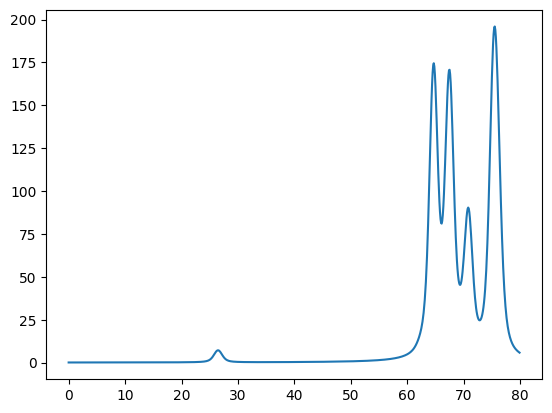

In [7]:
positions = np.array([[0,0,0],[0.5,0.5,0.5]])
atoms = ["Na","Cl"] #各原子位置の元素
B_list = np.array([5.0,15.0]) #等方性原子パラメータ
hkls = get_hkl(3) #hklリスト作成

lattice = jnp.array([5.43371  ,  3.9364023 , 5.6730223 , 0.79906535, 0.41158026 ,1.3640556 ])
lattice = jnp.array([4.3510303 , 4.7632937 , 3.0894952 , 0.87266463, 1.2217305,  0.87266463])
lattice = jnp.array([5.6600776 ,3.7745092 ,5.740381  ,0.7837088, 0.9939058 ,0.5057319])
lattice = jnp.array([5.066489 , 4.060722 , 6.249166 , 1.2228671, 0.576137,  0.6732659])
# lattice = jnp.array([4.02464,4.02464,4.02464,np.pi/3,np.pi/3,np.pi/3]) #格子定数?
#calc XRD
theta_limit=80
lamb=1.5418
B_list=jnp.array([2.0])
Hg = 1/5
Hl = 1/5
intensities = jnp.zeros(theta_limit*10)
invG = get_invG(*lattice)
#全サイトの寄与を合算して結晶構造因子Fを算出
form_factor = jnp.array(FORM_FACTOR.loc[atoms].values)
F = cal_F(hkls[1:],invG,positions,lamb,form_factor,theta_limit=theta_limit,B=B_list)
print(F)
theta2k = F[1]
t2 = jnp.arange(0, theta_limit, 0.1)
intensity = jnp.sum(jnp.real(F[0]),axis=1)**2
#畳み込み
vmap_voigt = vmap(voigt3,(None,0,0,None,None),0)
convoluted = vmap_voigt(t2,intensity.reshape(-1,1),theta2k.reshape(-1,1),0.5,0.5)
intensities = jnp.sum(convoluted,axis=0)

# theta2,intensity = get_XRD(hkls,lattice_param,positions,atoms,B_list=B_list)
plt.plot(t2,intensities)



## NaCl

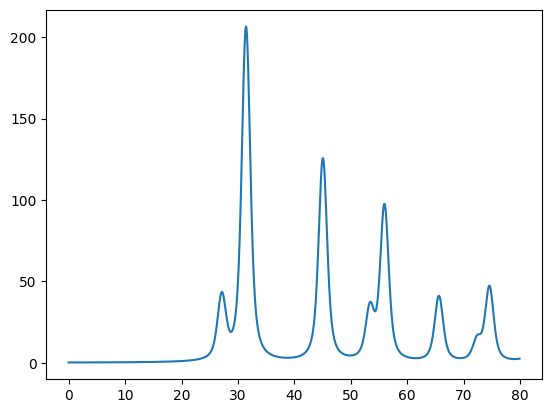

In [8]:
positions = np.array([[0,0,0],[0.5,0.5,0.5]])
atoms = ["Na","Cl"] #各原子位置の元素
B_list = np.array([5.0,15.0]) #等方性原子パラメータ
hkls = get_hkl(4) #hklリスト作成
lattice = jnp.array([4.02464,4.02464,4.02464,np.pi/3,np.pi/3,np.pi/3]) #格子定数

theta2,intensity = get_XRD(hkls,lattice,positions,atoms,B_list=B_list)
plt.plot(theta2,intensity)

## 逆解析

In [9]:
positions = np.array([[0,0,0],[0.5,0.5,0.5]])
atoms = ["Na","Cl"] #各原子位置の元素
B_list = np.array([5.0,15.0]) #等方性原子パラメータ
hkls = get_hkl(3) #hklリスト作成
lattice = jnp.array([4.02464,4.02464,4.02464,np.pi/3,np.pi/3,np.pi/3]) #格子定数
t2,true_spectrum = get_XRD(hkls,lattice,positions,atoms,B_list=B_list)

def L(lattice,draw=False,loss=False):
#     a,b,c = w[0],w[1],w[2]
    npt=800
    t2,pred_spectrum = get_XRD(hkls,lattice,positions,atoms,B_list=B_list)
    if draw:
        plt.plot(t2,pred_spectrum,label="pred")
    if loss:
        jnp.linalg.norm(pred_spectrum-true_spectrum)/npt #MSEではなくそのルートであるnormをとっているが最適化としては同じ。
    return jnp.linalg.norm(pred_spectrum-true_spectrum)/npt #MSEではなくそのルートであるnormをとっているが最適化としては同じ。

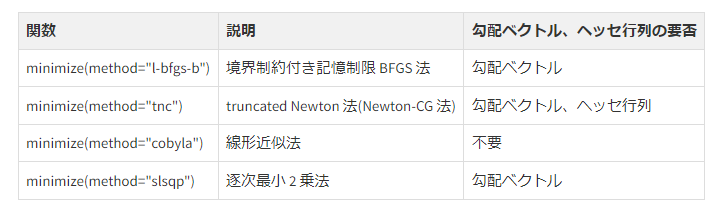

In [10]:
print(lattice)

[4.02464   4.02464   4.02464   1.0471976 1.0471976 1.0471976]


## loss関数のc軸長に対する変動

Text(0, 0.5, 'loss (mean squared error)')

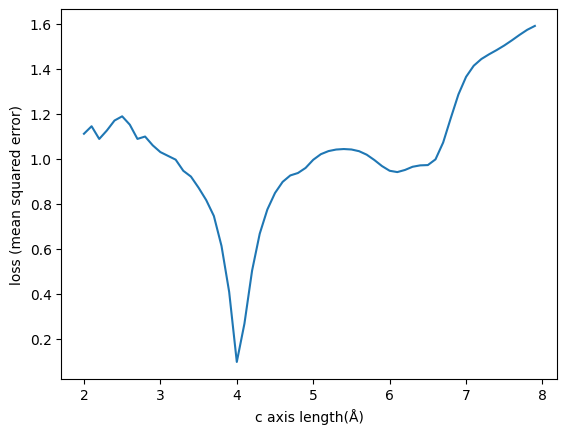

In [11]:
c_list = np.arange(2,8,0.1)
loss_history = []
for c in c_list:
    lattice = jnp.array([4.02464,4.02464,c,np.pi/3,np.pi/3,np.pi/3]) #格子定数
    loss = L(lattice)
    loss_history.append(loss)
plt.plot(c_list,loss_history)
plt.xlabel("c axis length(Å)")
plt.ylabel("loss (mean squared error)")

In [12]:
def get_lattice(a,b,c):
    return np.array([a,b,c,np.pi/3,np.pi/3,np.pi/3]) #格子定数

Text(0, 0.5, 'c (Å)')

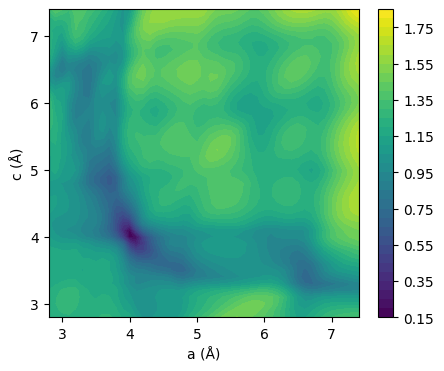

In [13]:
c_list = np.arange(2.8,7.5,0.1)
loss_all = []
for a in c_list:
    loss_list = []
    for b in c_list:
        lattice = np.array([a,4.02464,b,np.pi/3,np.pi/3,np.pi/3]) #格子定数
        loss = L(lattice)
        loss_list.append(loss)
    loss_all.append(loss_list)
plt.figure(figsize=(5,4))
A,B = np.meshgrid(c_list,c_list)
Z = np.array(loss_all)
plt.contourf(A,B,Z,levels=40)
plt.colorbar()
plt.xlabel("a (Å)")
plt.ylabel("c (Å)")


Text(0, 0.5, 'c (Å)')

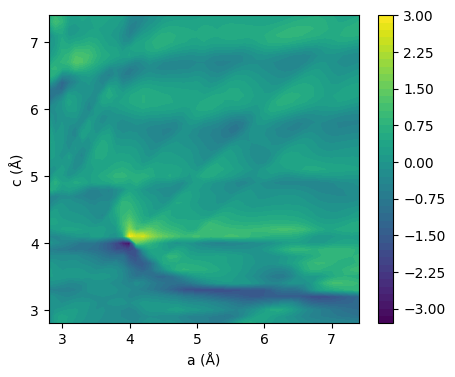

In [230]:
c_list = np.arange(2.8,7.5,0.1)
grad_L = grad(L)
loss_all = []
for a in c_list:
    loss_list = []
    for b in c_list:
        lattice = np.array([a,4.02464,b,np.pi/3,np.pi/3,np.pi/3]) #格子定数
        loss = grad_L(lattice)[0]
        loss_list.append(loss)
    loss_all.append(loss_list)
plt.figure(figsize=(5,4))
A,B = np.meshgrid(c_list,c_list)
Z = np.array(loss_all)
plt.contourf(A,B,Z,levels=40)
plt.colorbar()
plt.xlabel("a (Å)")
plt.ylabel("c (Å)")

In [14]:
import ipywidgets as widgets
%matplotlib inline
from IPython.display import display


def update_view(elev,azim):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection="3d")
    ax.plot_surface(A,B,Z,cmap="coolwarm")
    ax.view_init(elev=elev,azim=azim)
    ax.set_zlabel("loss")
    plt.xlabel("a (Å)")
    plt.ylabel("c (Å)")
    # plt.show()
elev_slider = widgets.IntSlider(value=30,min=-90,max=90,description="Elevation")
azim_slider = widgets.IntSlider(value=30,min=-90,max=90,description="Azimuth")
widgets.interact(update_view,elev=elev_slider,azim=azim_slider)

interactive(children=(IntSlider(value=30, description='Elevation', max=90, min=-90), IntSlider(value=30, descr…

<function __main__.update_view(elev, azim)>

Text(0, 0.5, 'alpha (rad.)')

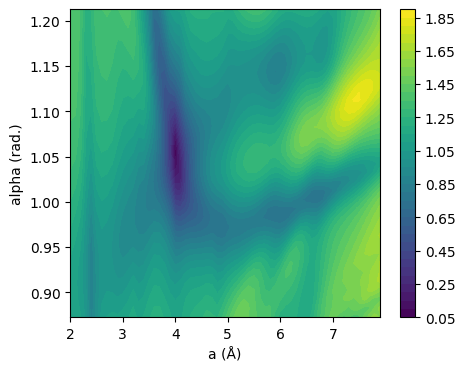

In [15]:
#a vs α
alpha_list = np.arange(np.deg2rad(50),np.deg2rad(70),0.01)
a_list = np.arange(2,8,0.1)
loss_all = []
for alpha in alpha_list:
    loss_list = []
    for a in a_list:
        lattice = np.array([a,4.02464,4.02464,alpha,np.pi/3,np.pi/3]) #格子定数
        loss = L(lattice)
        loss_list.append(loss)
    loss_all.append(loss_list)
    
plt.figure(figsize=(5,4))
A,Alpha = np.meshgrid(a_list,alpha_list)
Z = np.array(loss_all)
plt.contourf(A,Alpha,Z,levels=40)
plt.colorbar()
plt.xlabel("a (Å)")
plt.ylabel("alpha (rad.)")

In [16]:
lattice = jnp.array([4.02464,4.02464,4.02464,np.pi/3,np.pi/3,np.pi/3]) #格子定数
t2,true_spectrum = get_XRD(hkls,lattice,positions,atoms,B_list=B_list)

In [107]:
history = []
def callback(x):
    fobj = L(x) # 目的関数の値
    history.append(fobj) # リスト

In [119]:
# scipy optimize用optimizer関数
import jaxopt
def run_optimizer(optimizer,limited = True):
    global history
    lb_angle = np.deg2rad(50)
    ub_angle = np.deg2rad(70)
    w_init = jnp.array([4.02464,4.02464,3.1,np.pi/3,np.pi/3,np.pi/3])
    lower_bounds = jnp.array([3.0,3.0,3.0,lb_angle,lb_angle,lb_angle])
    upper_bounds = jnp.array([6.0,6.0,6.0,ub_angle,ub_angle,ub_angle])

    bounds = (lower_bounds, upper_bounds)
    if limited:
        lslsqp_sol = optimizer.run(w_init, bounds=bounds)
    else:
        lslsqp_sol = optimizer.run(w_init)
    print(lslsqp_sol)
    print(f"optimized param:{lslsqp_sol[0]}")
    print(f"true param:{lattice}")

    #最適化結果描画
    plt.plot(t2,true_spectrum+20,label="true")
    L(lslsqp_sol[0],draw=True)
    init_spec = get_XRD(hkls,w_init,positions,atoms,B_list=B_list)[1]
    plt.plot(t2,init_spec-20,label="init")
    plt.legend()
    plt.xlabel("2Θ(°)")
    plt.ylabel("Intensity(a.u.)")
    plt.show()
    #history
    plt.plot(history)
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.show()
    history = []

## SLSQP

OptStep(params=Array([4.107888 , 4.0854416, 3.       , 1.089335 , 1.0702449, 1.0595735],      dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(0.8298744, dtype=float32, weak_type=True), success=True, status=0, iter_num=11, hess_inv=None))
optimized param:[4.107888  4.0854416 3.        1.089335  1.0702449 1.0595735]
true param:[4.02464   4.02464   4.02464   1.0471976 1.0471976 1.0471976]


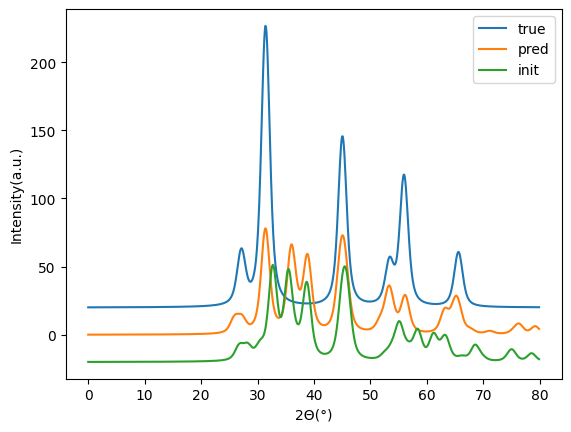

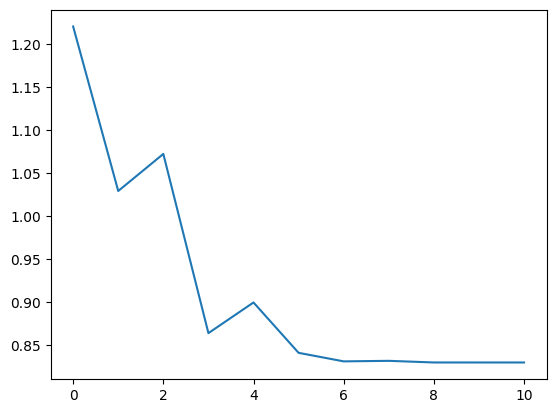

In [118]:
lslsqp = jaxopt.ScipyBoundedMinimize(fun=L, method="SLSQP", tol=1e-6,callback=callback) #jaxopt: projected grad(浮田さんが使用) src:https://jaxopt.github.io/stable/constrained.html#projected-gradient
run_optimizer(lslsqp)

## Nelder-Mead(not 微分)

/home/wakazaki/miniconda3/envs/PIAI/lib/python3.8/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


OptStep(params=Array([4.3273435, 4.0429053, 3.1657884, 1.0768601, 1.2217305, 1.2094022],      dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(0.55801255, dtype=float32), success=True, status=0, iter_num=370, hess_inv=None))
optimized param:[4.3273435 4.0429053 3.1657884 1.0768601 1.2217305 1.2094022]
true param:[4.02464   4.02464   4.02464   1.0471976 1.0471976 1.0471976]


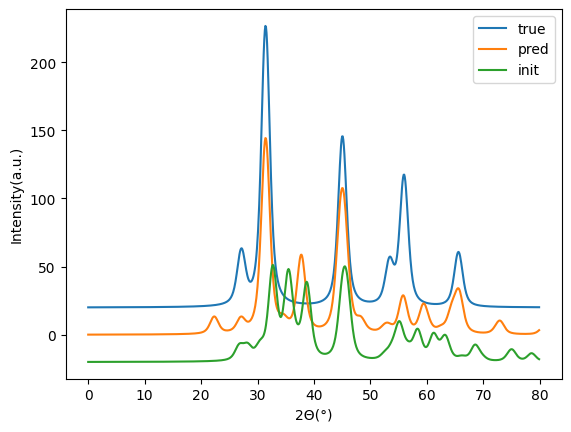

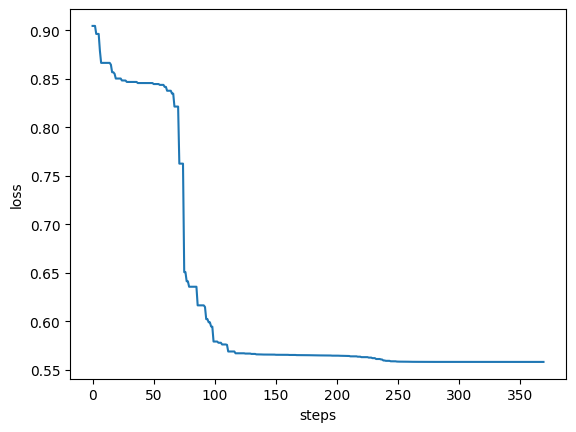

In [120]:
lslsqp = jaxopt.ScipyBoundedMinimize(fun=L, method="nelder-mead",tol=1e-6,callback=callback) #jaxopt: projected grad(浮田さんが使用) src:https://jaxopt.github.io/stable/constrained.html#projected-gradient
run_optimizer(lslsqp)

## Truncated Newton Method(Hessian-Free)

OptStep(params=Array([4.0336456, 3.9867601, 4.0039444, 1.0649502, 1.059461 , 1.0614008],      dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(0.13698857, dtype=float32, weak_type=True), success=False, status=3, iter_num=14, hess_inv=None))
optimized param:[4.0336456 3.9867601 4.0039444 1.0649502 1.059461  1.0614008]
true param:[7.4        4.02464    7.4        1.04719755 1.04719755 1.04719755]


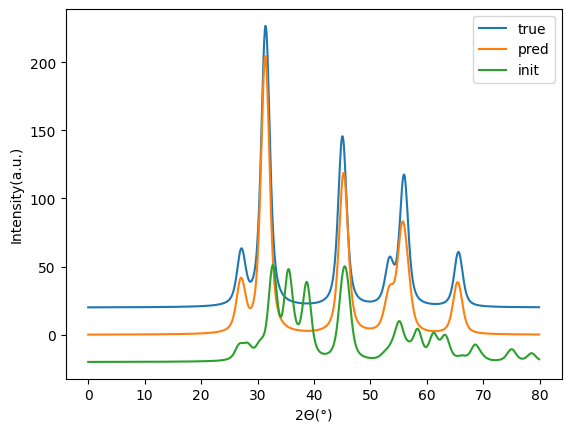

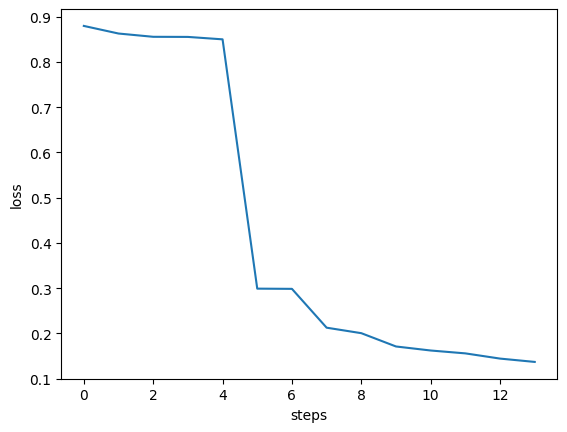

In [257]:
lslsqp = jaxopt.ScipyBoundedMinimize(fun=L, method="tnc",tol=1e-5,maxiter=100,callback=callback) #jaxopt: projected grad(浮田さんが使用) src:https://jaxopt.github.io/stable/constrained.html#projected-gradient
run_optimizer(lslsqp)

## projected gradient

[4.170124  4.0309315 3.3292077 1.0689435 1.1827496 1.1588633]


Text(0, 0.5, 'Intensity(a.u.)')

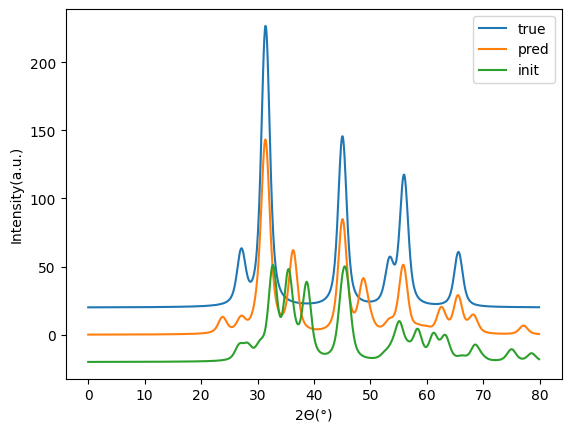

In [21]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative,projection_box
lb_angle = np.deg2rad(50)
ub_angle = np.deg2rad(70)
w_init = jnp.array([4.02464,4.02464,3.1,np.pi/3,np.pi/3,np.pi/3])
lower_bounds = jnp.array([3.0,3.0,3.0,lb_angle,lb_angle,lb_angle])
upper_bounds = jnp.array([6.0,6.0,6.0,ub_angle,ub_angle,ub_angle])

bounds = (lower_bounds, upper_bounds)
pg = ProjectedGradient(fun=L, projection=projection_box)
pg_sol = pg.run(w_init,hyperparams_proj=bounds).params
print(pg_sol)

#最適化結果描画
plt.plot(t2,true_spectrum+20,label="true")
L(pg_sol,draw=True)
init_spec = get_XRD(hkls,w_init,positions,atoms,B_list=B_list)[1]
plt.plot(t2,init_spec-20,label="init")
plt.legend()
plt.xlabel("2Θ(°)")
plt.ylabel("Intensity(a.u.)")

## Newton法

/home/wakazaki/miniconda3/envs/PIAI/lib/python3.8/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method newton-cg cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


OptStep(params=Array([4.02464  , 4.02464  , 3.1      , 1.0471976, 1.0471976, 1.0471976],      dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(1.0130618, dtype=float32, weak_type=True), success=True, status=0, iter_num=1, hess_inv=None))
optimized param:[4.02464   4.02464   3.1       1.0471976 1.0471976 1.0471976]
true param:[4.02464   4.02464   4.02464   1.0471976 1.0471976 1.0471976]


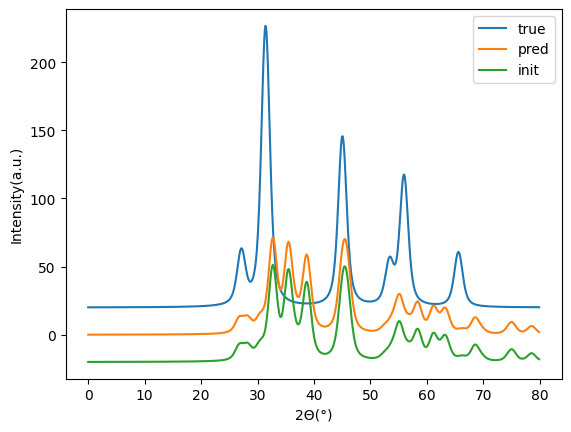

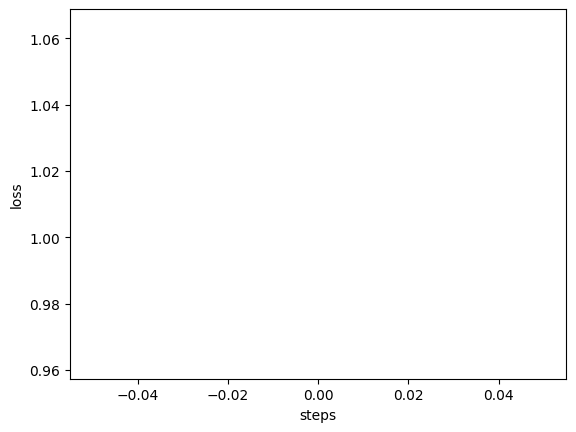

In [122]:
newton = jaxopt.ScipyBoundedMinimize(fun=L, method="newton-cg",tol=1e-6,maxiter=100,callback=callback) #jaxopt: projected grad(浮田さんが使用) src:https://jaxopt.github.io/stable/constrained.html#projected-gradient
run_optimizer(newton)

In [23]:
# lslsqp = jaxopt.ScipyBoundedMinimize(fun=L, method="nelder-mead",tol=1e-6) #jaxopt: projected grad(浮田さんが使用) src:https://jaxopt.github.io/stable/constrained.html#projected-gradient
# lslsqp = jaxopt.ScipyBoundedMinimize(fun=L, method="SLSQP",tol=1e-6,options={"finite_diff_rel_step":1e-6},maxiter=100) #jaxopt: projected grad(浮田さんが使用) src:https://jaxopt.github.io/stable/constrained.html#projected-gradient
# lslsqp = jaxopt.ScipyBoundedMinimize(fun=L,
#                                      method="l-bfgs-b",
#                                      tol=1e-6,
#                                      options={"maxfun":20,"maxls":200,"ftol":0.01,"gtol":0.1,"disp":True},
#                                      maxiter=100)
# lslsqp = jaxopt.ScipyBoundedMinimize(fun=L, method="tnc",tol=1e-6,maxiter=100) #jaxopt: projected grad(浮田さんが使用) src:https://jaxopt.github.io/stable/constrained.html#projected-gradient

#中野さん：微分してscipyのoptimizeに持っていく。scipyのNewton法などで使用経験あり

## 最急降下法

100%|██████████| 200/200 [00:06<00:00, 33.30it/s]


Optimal parameters: [4.176025  4.028678  3.326781  1.0700688 1.1839927 1.1611915]


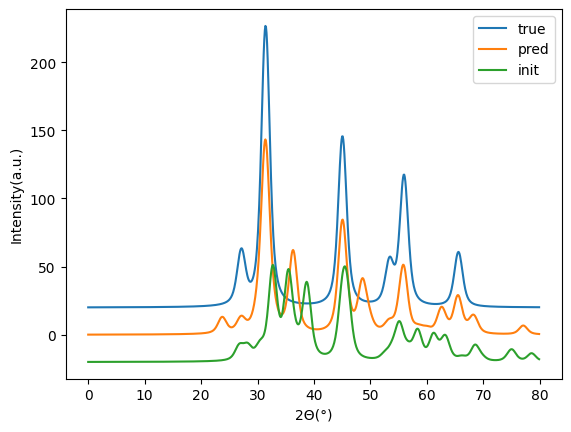

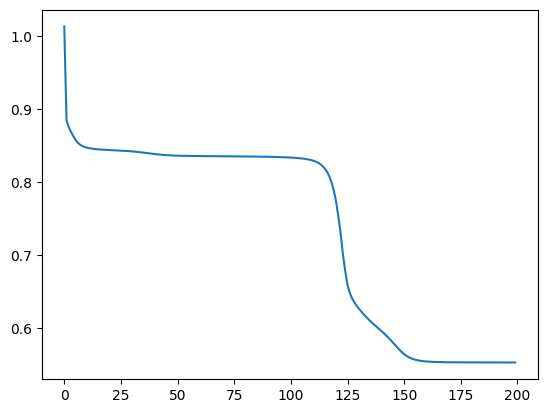

In [59]:
from jax import grad, random
from tqdm import tqdm
grad_loss_func = grad(L)

lower_bounds = jnp.array([3.0,3.0,3.0,lb_angle,lb_angle,lb_angle])
upper_bounds = jnp.array([6.0,6.0,6.0,ub_angle,ub_angle,ub_angle])
bounds = (lower_bounds, upper_bounds)

w_init = jnp.array([4.02464,4.02464,3.1,np.pi/3,np.pi/3,np.pi/3])
init_spec = get_XRD(hkls,w_init,positions,atoms,B_list=B_list)[1]

learning_rate = 0.008
num_epochs = 200
param_history = []
loss_history = []
for epoch in tqdm(range(num_epochs)):
    gradient = grad_loss_func(w_init)
    loss_history.append(L(w_init,loss=True))
    if np.isnan(np.array(gradient)[0]):
        print("NaN value!")
        break
    w_init -= learning_rate * gradient
    param_history.append(w_init)
print("Optimal parameters:",w_init)

#結果描画
plt.plot(t2,true_spectrum+20,label="true")
L(w_init,draw=True)
plt.plot(t2,init_spec-20,label="init")
plt.legend()
plt.xlabel("2Θ(°)")
plt.ylabel("Intensity(a.u.)")
plt.show()
#loss履歴描画
plt.plot(loss_history)

## ミニバッチ

In [25]:
def L_batch(lattice,t2index,draw=False,loss=False):
#     a,b,c = w[0],w[1],w[2]
    npt=800
    t2,pred_spectrum = get_XRD(hkls,lattice,positions,atoms,B_list=B_list)
    if draw:
        plt.plot(t2,pred_spectrum,label="pred")
    if loss:
        return np.linalg.norm(pred_spectrum[t2index]-true_spectrum[t2index])/npt
#     return jnp.linalg.norm(pred_spectrum[t2index]-true_spectrum[t2index])/npt #MSEではなくそのルートであるnormをとっているが最適化としては同じ。
    return jnp.mean(((pred_spectrum[t2index]-true_spectrum[t2index]))**2)/npt

100%|██████████| 20/20 [01:01<00:00,  3.06s/it]

Optimal parameters: [4.077943  4.039653  3.7564454 0.9734229 1.0886959 0.9772999]
gradient: [-0.7050072  -1.0094987   0.37351847  2.3283708  -6.982402   -1.0073466 ]


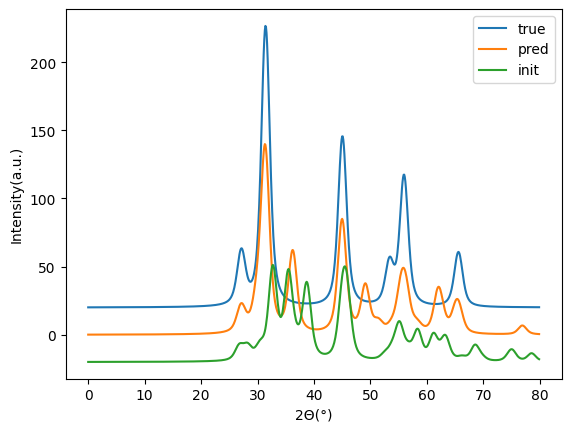

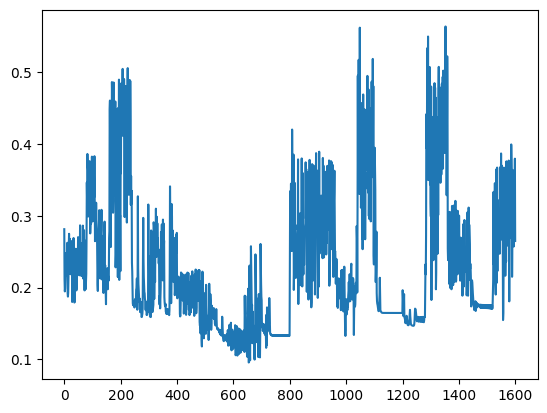

In [26]:
from jax import grad, random
from tqdm import tqdm
grad_loss_func = grad(L_batch)

lower_bounds = jnp.array([3.0,3.0,3.0,lb_angle,lb_angle,lb_angle])
upper_bounds = jnp.array([6.0,6.0,6.0,ub_angle,ub_angle,ub_angle])
bounds = (lower_bounds, upper_bounds)

w_init = jnp.array([4.02464,4.02464,3.1,np.pi/3,np.pi/3,np.pi/3])
init_spec = get_XRD(hkls,w_init,positions,atoms,B_list=B_list)[1]

learning_rate = 0.01
num_epochs = 80
random_size = 20
selected_points = 80 #best:80
param_history = []
loss_history = []
for seed in tqdm(range(random_size)):
    for epoch in range(num_epochs):
        key = random.PRNGKey(seed)
        t2index = random.randint(key,shape=(selected_points,),minval=1,maxval=799)
        gradient = grad_loss_func(w_init,t2index)
        loss_history.append(L_batch(w_init,t2index,loss=True))
        if np.isnan(np.array(gradient)[0]):
            print("NaN value!")
            break
        w_init -= learning_rate * gradient
        w_init = jnp.clip(w_init,lower_bounds,upper_bounds)
#         print(w_init)
        param_history.append(w_init)
print("Optimal parameters:",w_init)
print("gradient:",gradient)
#結果描画
plt.plot(t2,true_spectrum+20,label="true")
L(w_init,draw=True)
plt.plot(t2,init_spec-20,label="init")
plt.legend()
plt.xlabel("2Θ(°)")
plt.ylabel("Intensity(a.u.)")
plt.show()
#lossの履歴を表示
plt.plot(loss_history)

## Momentum

In [27]:
import jax.numpy as jnp
from jax import grad, jit, value_and_grad
from jax import random

def sgd_momentum(gradient, x, velocity,momentum, lr=0.01):
    # velocity = jnp.zeros_like(x)
    # velocity = momentum * velocity - lr * gradient(x)
    velocity = momentum * velocity - lr * gradient
    x = x + velocity
    return x, velocity

def train_sgd_momentum(params, x, y, epochs, batch_size, momentum=0.9, lr=0.01):
    opt_step = jit(sgd_momentum)
    num_batches = x.shape[0] // batch_size
    for i in range(epochs):
        idx = jnp.arange(x.shape[0])
        rand = random.permutation(random.PRNGKey(i))
        for j in range(num_batches):
            batch_idx = idx[j*batch_size:(j+1)*batch_size]
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]
            params, velocity = opt_step(value_and_grad(loss)(params, x_batch, y_batch), params, momentum, lr)
        if i % 100 == 0:
            print(f"Epoch {i}, Loss {loss(params, x, y)}")
    return params

100%|██████████| 40/40 [01:00<00:00,  1.50s/it]

Optimal parameters: [4.0296574 4.0246553 4.0198545 1.04785   1.0470937 1.047185 ]
gradient: [ 4.3989503e-04  5.4212369e-06 -4.0223618e-04  4.6500620e-05
 -6.6408916e-06 -4.8616585e-06]


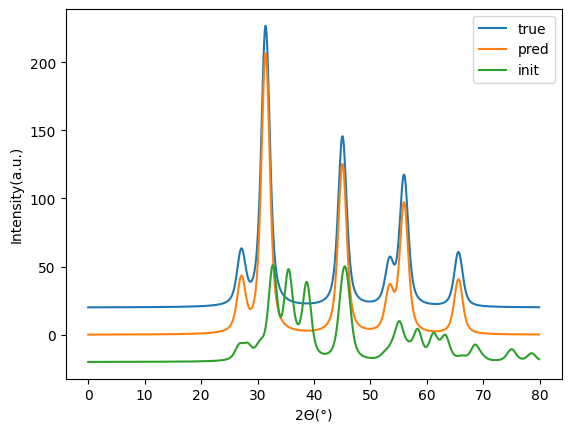

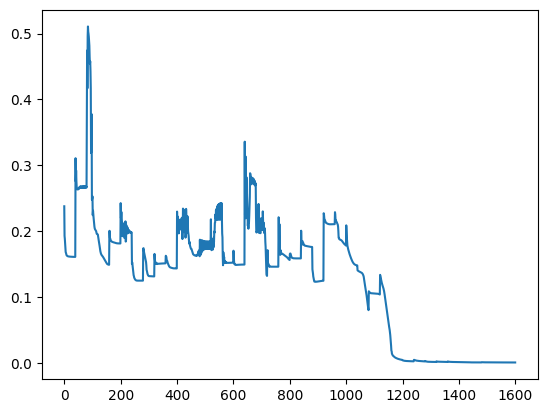

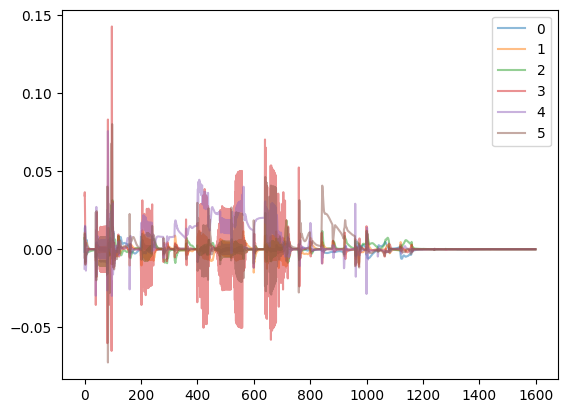

In [64]:
w_init = jnp.array([4.02464,4.02464,3.1,np.pi/3,np.pi/3,np.pi/3])
# w_init = jnp.array([6,4.02464,6,np.pi/3,np.pi/3,np.pi/3])
learning_rate = 0.005
velocity = jnp.zeros_like(w_init)
momentum = 0.5 #0.5 for optimal
num_epochs = 40
random_size = 40
selected_points = 80 #best:80
param_history = []
loss_history = []
velocities = []
grad_loss_func = grad(L_batch)
for seed in tqdm(range(random_size)):
    for epoch in range(num_epochs):
        key = random.PRNGKey(seed)
        t2index = random.randint(key,shape=(selected_points,),minval=1,maxval=799)
        gradient = grad_loss_func(w_init,t2index)
        old_param = w_init
        w_init,velocity = sgd_momentum(gradient,w_init,velocity,momentum,lr=learning_rate)
        velocities.append(velocity)
        loss_history.append(L_batch(w_init,t2index,loss=True))
        if np.isnan(np.array(gradient)[0]):
            print("NaN value!")
            print(old_param)
            break
        # w_init -= learning_rate * gradient
        w_init = jnp.clip(w_init,lower_bounds,upper_bounds)
#         print(w_init)
        param_history.append(w_init)
print("Optimal parameters:",w_init)
print("gradient:",gradient)
#結果描画
plt.plot(t2,true_spectrum+20,label="true")
L(w_init,draw=True)
plt.plot(t2,init_spec-20,label="init")
plt.legend()
plt.xlabel("2Θ(°)")
plt.ylabel("Intensity(a.u.)")
plt.show()
#lossの履歴を表示
plt.plot(loss_history)
plt.show()
#velocityの履歴を表示
velocities = np.array(velocities)
for i in range(velocities.shape[1]):
    plt.plot(velocities[:,i],label=i,alpha=0.5)
plt.legend()
plt.show()

## Optimizerクラスとしての定義
- 最適化および比較の簡素化のため、Optimizerをクラスとして定義

In [29]:
def extend_window(lst,window,min_value=1,max_value=799):
    result = []
    for i in range(len(lst)):
        start = max(lst[i],min_value)
        end = min(lst[i]+window,max_value)
        result.extend(range(start,end+1))
    return jnp.array(result)

In [68]:
class momentum_optimizer():
    def __init__(self,w_init,grad_loss_func,params,threshold=1e-3):
        self.threshold = threshold
        self.w_init = w_init
        self.grad_loss_func = grad_loss_func
        self.learning_rate = params["learning_rate"]
        self.velocity = jnp.zeros_like(w_init)
        self.momentum = params["momentum"]
        self.num_epochs = params["num_epochs"]
        self.random_size = params["random_size"]
        self.selected_points = params["selected_points"]
        self.velocities = []
        self.loss_history = []
        self.param_history = []
    def optimize(self):
        for seed in tqdm(range(self.random_size)):
            key = random.PRNGKey(seed)
            t2index = random.randint(key,shape=(self.selected_points,),minval=1,maxval=799)
            # t2index = extend_window(t2index,10) #window分だけ選択範囲を拡張
            for epoch in range(self.num_epochs):
                gradient = self.grad_loss_func(self.w_init,t2index)
                old_param = self.w_init
                self.w_init,self.velocity = sgd_momentum(gradient,self.w_init,self.velocity,self.momentum,lr=self.learning_rate)
                self.velocities.append(self.velocity)
                self.loss_history.append(L_batch(self.w_init,t2index,loss=True))
                self.w_init = jnp.clip(self.w_init,lower_bounds,upper_bounds)
                self.param_history.append(self.w_init)
                if np.isnan(np.array(gradient)[0]):
                    # print("NaN value!")
                    print(old_param)
                    break
            else:
                if self.loss_history[-1] < self.threshold:
                    break
                continue
            break
        return self.w_init

In [66]:
def optimize_XRD(params,optimizer,draw_graph=True):
    w_init = jnp.array([4.02464,4.02464,3.1,np.pi/3,np.pi/3,np.pi/3])
    # w_init = jnp.array([6,4.02464,6,np.pi/3,np.pi/3,np.pi/3])
    
    grad_loss_func = grad(L_batch)
    optimizer_obj = optimizer(w_init,grad_loss_func,params)
    w_init = optimizer_obj.optimize()
    
    if draw_graph:
        print("Optimal parameters:",w_init)
        # print("gradient:",gradient)

        #結果描画
        plt.plot(t2,true_spectrum+20,label="true")
        L(w_init,draw=True)
        plt.plot(t2,init_spec-20,label="init")
        plt.legend()
        plt.xlabel("2Θ(°)")
        plt.ylabel("Intensity(a.u.)")
        plt.show()
        #lossの履歴を表示
        plt.plot(optimizer_obj.loss_history)
        plt.show()
    return optimizer_obj
    #velocityの履歴を表示
    # velocities = np.array(optimizer_obj.velocities)
    # for i in range(velocities.shape[1]):
    #     plt.plot(velocities[:,i],label=i,alpha=0.5)
    # plt.legend()
    # plt.show()

 34%|███▍      | 34/100 [00:50<01:38,  1.49s/it]

Optimal parameters: [4.030935  4.0244017 4.018164  1.0490022 1.0472031 1.0465496]


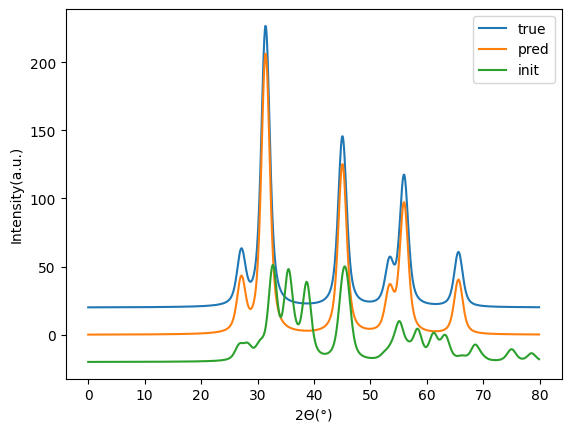

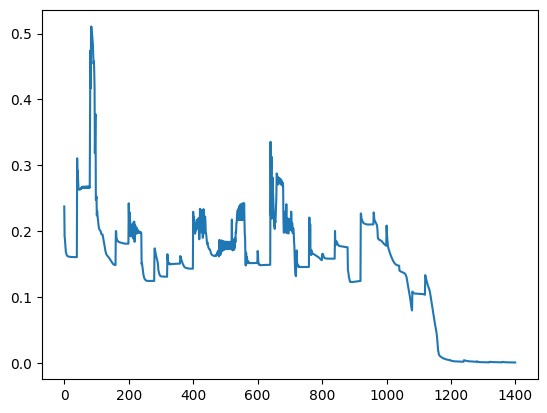

In [69]:
momentum_params = {"learning_rate":0.005,"momentum":0.5,"num_epochs":40,"random_size":100,"selected_points":80}
optimize_XRD(momentum_params,momentum_optimizer)

## Adam

In [70]:
def adam(gradient, x, m, v, t, beta1=0.9, beta2=0.999, eps=1e-8, lr=0.001):
    m = beta1 * m + (1 - beta1) * gradient
    v = beta2 * v + (1 - beta2) * gradient**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    x = x - lr * m_hat / (jnp.sqrt(v_hat) + eps)
    return x, m, v

def train_adam(params, x, y, epochs, batch_size, beta1=0.9, beta2=0.999, eps=1e-8, lr=0.001):
    opt_step = jit(adam)
    m = jnp.zeros_like(params)
    v = jnp.zeros_like(params)
    num_batches = x.shape[0] // batch_size
    t = 1
    for i in range(epochs):
        idx = jnp.arange(x.shape[0])
        rand = random.permutation(random.PRNGKey(i))
        for j in range(num_batches):
            batch_idx = idx[j*batch_size:(j+1)*batch_size]
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]
            params, m, v = opt_step(value_and_grad(loss)(params, x_batch, y_batch), params, m, v, t, beta1, beta2, eps, lr)
            t += 1
        if i % 100 == 0:
            print(f"Epoch {i}, Loss {loss(params, x, y)}")
    return params
class Adam_optimizer():
    def __init__(self,w_init,grad_loss_func,params,threshold=1e-3):
        self.threshold = threshold
        self.w_init = w_init
        self.grad_loss_func = grad_loss_func
        self.velocity = jnp.zeros_like(w_init)
        self.learning_rate = params["learning_rate"]
        self.beta1 = params["beta1"]
        self.beta2 = params["beta2"]
        self.eps = params["eps"]
        self.num_epochs = params["num_epochs"]
        self.random_size = params["random_size"]
        self.selected_points = params["selected_points"]
        self.velocities = []
        self.loss_history = []
        self.param_history = []
    def optimize(self):
        opt_step = jit(adam)
        m = jnp.zeros_like(self.w_init)
        v = jnp.zeros_like(self.w_init)
        t = 1
        for seed in tqdm(range(self.random_size)):
            key = random.PRNGKey(seed)
            t2index = random.randint(key,shape=(self.selected_points,),minval=1,maxval=799)
            # t2index = extend_window(t2index,10) #window分だけ選択範囲を拡張
            for epoch in range(self.num_epochs):
                gradient = self.grad_loss_func(self.w_init,t2index)
                old_param = self.w_init
                self.w_init, m, v = opt_step(gradient, self.w_init, m, v, t, self.beta1, self.beta2, self.eps, self.learning_rate)
                t += 1
                self.velocities.append(v)
                self.loss_history.append(L_batch(self.w_init,t2index,loss=True))
                self.w_init = jnp.clip(self.w_init,lower_bounds,upper_bounds)
                self.param_history.append(self.w_init)
                if np.isnan(np.array(gradient)[0]):
                    print("NaN value!")
                    print(old_param)
                    break
            else:

                if self.loss_history[-1] < self.threshold:
                    break
                continue
            break
        return self.w_init

  1%|          | 6/500 [00:05<06:54,  1.19it/s]

Optimal parameters: [4.0212803 4.025738  4.028269  1.045926  1.0465261 1.0478162]


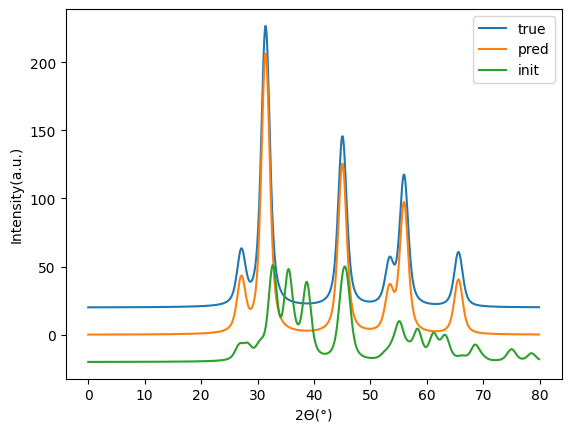

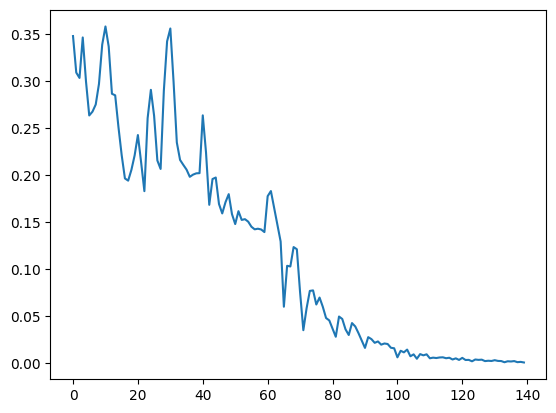

In [126]:
adam_params = {"beta1":0.9, "beta2":0.999, "eps":1e-8, "learning_rate":0.2,"num_epochs":20,"random_size":500,"selected_points":80}
#adam_params = {"beta1":0.9, "beta2":0.999, "eps":1e-8, "learning_rate":0.2,"num_epochs":20,"random_size":500,"selected_points":80}: 120 steps
optimize_XRD(adam_params,Adam_optimizer)

## RMSprop

In [72]:
def rmsprop(gradient, x, cache, decay_rate=0.9, lr=0.001, eps=1e-8):
    cache = decay_rate * cache + (1 - decay_rate) * gradient**2
    x = x - lr * gradient / (jnp.sqrt(cache) + eps)
    return x, cache

def train_rmsprop(params, x, y, epochs, batch_size, decay_rate=0.9, lr=0.001, eps=1e-8):
    opt_step = jit(rmsprop)
    cache = jnp.zeros_like(params)
    num_batches = x.shape[0] // batch_size
    for i in range(epochs):
        idx = jnp.arange(x.shape[0])
        rand = random.permutation(random.PRNGKey(i))
        for j in range(num_batches):
            batch_idx = idx[j*batch_size:(j+1)*batch_size]
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]
            params, cache = opt_step(value_and_grad(loss)(params, x_batch, y_batch), params, cache, decay_rate, lr, eps)
        if i % 100 == 0:
            print(f"Epoch {i}, Loss {loss(params, x, y)}")
    return params

class RMSprop_optimizer():
    def __init__(self,w_init,grad_loss_func,params,threshold=1e-3):
        self.threshold = threshold
        self.w_init = w_init
        self.grad_loss_func = grad_loss_func
        self.velocity = jnp.zeros_like(w_init)
        self.learning_rate = params["learning_rate"]
        self.decay_rate = params["decay_rate"]
        self.eps = params["eps"]
        self.num_epochs = params["num_epochs"]
        self.random_size = params["random_size"]
        self.selected_points = params["selected_points"]
        self.velocities = []
        self.loss_history = []
        self.param_history = []
    def optimize(self):
        opt_step = jit(rmsprop)
        cache = jnp.zeros_like(self.w_init)
        for seed in tqdm(range(self.random_size)):
            key = random.PRNGKey(seed)
            t2index = random.randint(key,shape=(self.selected_points,),minval=1,maxval=799)
            # t2index = extend_window(t2index,10) #window分だけ選択範囲を拡張
            for epoch in range(self.num_epochs):
                gradient = self.grad_loss_func(self.w_init,t2index)
                old_param = self.w_init
                self.w_init, cache = opt_step(gradient, self.w_init, cache, self.decay_rate,self.learning_rate,self.eps)
                self.loss_history.append(L_batch(self.w_init,t2index,loss=True))
                self.w_init = jnp.clip(self.w_init,lower_bounds,upper_bounds)
                self.param_history.append(self.w_init)
                if np.isnan(np.array(gradient)[0]):
                    # print("NaN value!")
                    # print(old_param)
                    break
            else:

                if self.loss_history[-1] < self.threshold:
                    break
                continue
            break
        return self.w_init

 55%|█████▌    | 11/20 [00:43<00:35,  3.97s/it]

Optimal parameters: [4.023012  4.0200634 4.0305433 1.0457355 1.0474002 1.0477123]


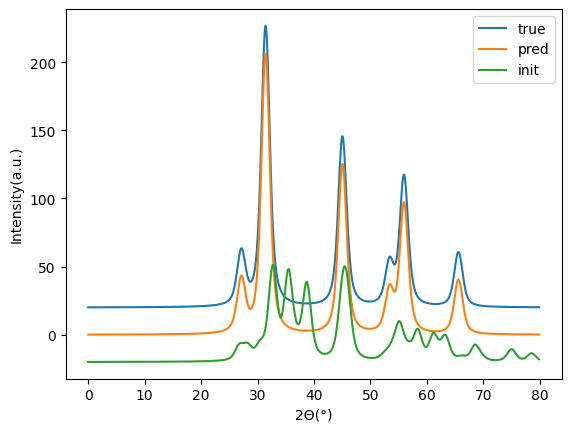

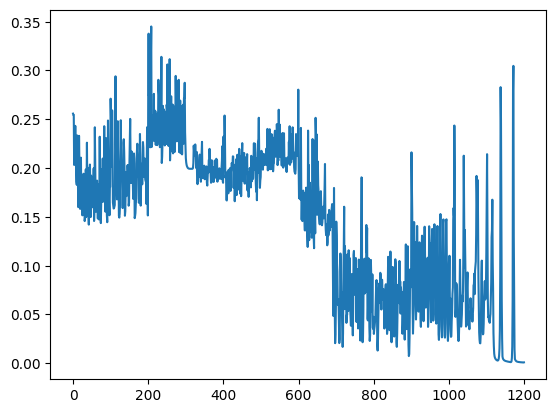

In [93]:
rmsprop_params = {"decay_rate":0.9, "eps":1e-8, "learning_rate":0.03,"num_epochs":100,"random_size":20,"selected_points":80}
optimize_XRD(rmsprop_params,RMSprop_optimizer)

## AdaGrad

In [37]:
# def adagrad(gradient, x, cache, lr=0.01, eps=1e-8):
#     cache = cache + gradient(x)**2
#     x = x - lr * gradient(x) / (jnp.sqrt(cache) + eps)
#     return x, cache

# def train_adagrad(params, x, y, epochs, batch_size, lr=0.01, eps=1e-8):
#     opt_step = jit(adagrad)
#     cache = jnp.zeros_like(params)
#     num_batches = x.shape[0] // batch_size
#     for i in range(epochs):
#         idx = jnp.arange(x.shape[0])
#         rand = random.permutation(random.PRNGKey(i))
#         for j in range(num_batches):
#             batch_idx = idx[j*batch_size:(j+1)*batch_size]
#             x_batch = x[batch_idx]
#             y_batch = y[batch_idx]
#             params, cache = opt_step(value_and_grad(loss)(params, x_batch, y_batch), params, cache, lr, eps)
#         if i % 100 == 0:
#             print(f"Epoch {i}, Loss {loss(params, x, y)}")
#     return params

## Truncated newton method (Hessian)
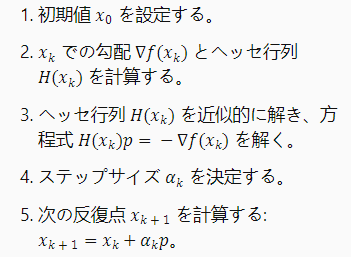

In [168]:
def min_max_scale(x,upper_bounds,lower_bounds):
    return (x-lower_bounds)/upper_bounds

In [259]:
import jax.numpy as jnp
from jax import grad, jit, vmap,hessian
from jax import random

loss_history = []
param_history = []
def truncated_newton(f, x0, maxiter=100, gtol=1e-5,scale=None):
    x = x0
    for i in range(maxiter):
        loss_history.append(f(x))
        param_history.append(x)
        g = grad(f)(x)
        # h = grad(grad(f))(x)
        h = hessian(f)(x)
        if scale != None:
            p = -jnp.linalg.solve(h, g)*scale
        else:
            p = -jnp.linalg.solve(h, g)
        alpha = 1
        while f(x + alpha * p) > f(x) + 1e-6 * alpha * jnp.dot(g, p): #        while f(x + alpha * p) > f(x) + 1e-4 * alpha * jnp.dot(g, p):
            alpha *= 0.5
        x = x + alpha * p

        if jnp.abs(g).max() < gtol:
            break
    return x

# Example usage:
f = lambda x: (x[0] - 1)**2 + 2*(x[1] - 2.5)**4
x0 = jnp.array([0., 0.])
x_min = truncated_newton(f, x0)

print("Minimum found at:", x_min)
print(loss_history)

Minimum found at: [1.        2.4942908]
[Array(79.125, dtype=float32), Array(15.432097, dtype=float32), Array(3.0483162, dtype=float32), Array(0.6021365, dtype=float32), Array(0.11894048, dtype=float32), Array(0.02349444, dtype=float32), Array(0.00464088, dtype=float32), Array(0.00091672, dtype=float32), Array(0.00018108, dtype=float32), Array(3.5768997e-05, dtype=float32), Array(7.065429e-06, dtype=float32), Array(1.3956403e-06, dtype=float32), Array(2.7567745e-07, dtype=float32), Array(5.4454805e-08, dtype=float32), Array(1.0756906e-08, dtype=float32)]


[3.         3.         3.         0.34906584 0.34906584 0.34906584]
Minimum found at: [4.02464   4.02464   3.0999968 1.0471976 1.0471976 1.0471976]


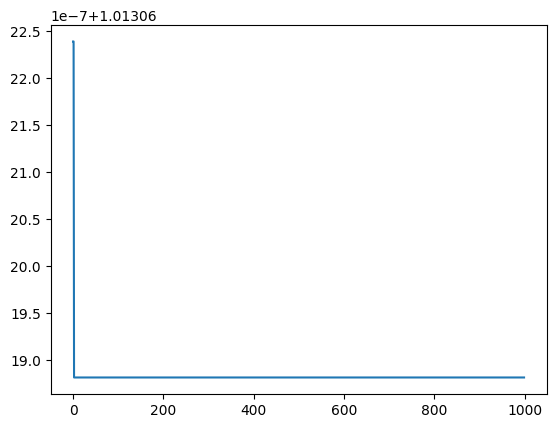

In [260]:
param_history = []
loss_history = []
w_init = jnp.array([4.02464,4.02464,3.1,np.pi/3,np.pi/3,np.pi/3])
scale = upper_bounds-lower_bounds
print(scale)
x_min = truncated_newton(L,w_init,maxiter=1000,scale=scale/50)
print("Minimum found at:", x_min)
plt.plot(loss_history)

In [ ]:
class TN_optimizer():
    def __init__(self,w_init,grad_loss_func,params,threshold=1e-3):
        self.threshold = threshold
        self.w_init = w_init
        self.grad_loss_func = grad_loss_func
        self.velocity = jnp.zeros_like(w_init)
        self.learning_rate = params["learning_rate"]
        self.decay_rate = params["decay_rate"]
        self.eps = params["eps"]
        self.num_epochs = params["num_epochs"]
        self.random_size = params["random_size"]
        self.selected_points = params["selected_points"]
        self.velocities = []
        self.loss_history = []
        self.param_history = []
    def optimize(self):
        
        opt_step = jit(rmsprop)
        cache = jnp.zeros_like(self.w_init)
        for seed in tqdm(range(self.random_size)):
            key = random.PRNGKey(seed)
            t2index = random.randint(key,shape=(self.selected_points,),minval=1,maxval=799)
            # t2index = extend_window(t2index,10) #window分だけ選択範囲を拡張
            for epoch in range(self.num_epochs):
                gradient = self.grad_loss_func(self.w_init,t2index)
                old_param = self.w_init
                self.w_init, cache = opt_step(gradient, self.w_init, cache, self.decay_rate,self.learning_rate,self.eps)
                self.loss_history.append(L_batch(self.w_init,t2index,loss=True))
                self.w_init = jnp.clip(self.w_init,lower_bounds,upper_bounds)
                self.param_history.append(self.w_init)
                if np.isnan(np.array(gradient)[0]):
                    # print("NaN value!")
                    # print(old_param)
                    break
            else:

                if self.loss_history[-1] < self.threshold:
                    break
                continue
            break
        return self.w_init

## 参考文献
- [最適化アルゴリズムの図解](https://qiita.com/omiita/items/1735c1d048fe5f611f80)

## XRDパターンの変動アニメーション

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython import display 

def get_pattern_animation(parameters):
    fig = plt.figure()
    # データの作成
    frames = []
    num_frames = len(parameters)
    print(num_frames)
    for i in range(num_frames):
        w_init = parameters[i]
        pattern = get_XRD(hkls,w_init,positions,atoms,B_list=B_list)[1]
        frame = plt.plot(t2, pattern, color='blue')[0]
        frames.append([frame])

    # 描画
    ani = ArtistAnimation(fig, frames, interval=100)
    html = display.HTML(ani.to_jshtml())
    display.display(html)
    plt.close()

## 最適化性能比較

 55%|█████▌    | 11/20 [00:43<00:35,  3.92s/it]


[]

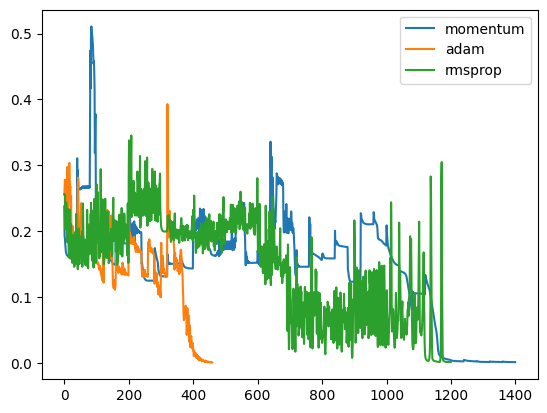

In [94]:
methods = ["momentum","adam","rmsprop"]
optimizer_params = {"momentum":momentum_params,"adam":adam_params,"rmsprop":rmsprop_params}
optimizers = {"momentum":momentum_optimizer,"adam":Adam_optimizer,"rmsprop":RMSprop_optimizer}
history = {}
for method in methods:
    # rmsprop_params = {"decay_rate":0.5, "eps":1e-8, "learning_rate":0.01,"num_epochs":40,"random_size":200,"selected_points":80}
    result = optimize_XRD(optimizer_params[method],optimizers[method],draw_graph=False)
    history[method] = result
    plt.plot(result.loss_history,label=method)
plt.legend()
plt.plot()

## windowを設けた場合のoptuna後パラメータ
{'momentum': {'learning_rate': 0.002719235737724673, 'momentum': 0.48953444628847986, 'num_epochs': 31, 'random_size': 20, 'selected_points': 10}, 'adam': {'beta1': 0.6798575405485341, 'beta2': 0.6937337417521882, 'eps': 1.008207608422183e-10, 'learning_rate': 0.001875986108022089, 'num_epochs': 10, 'random_size': 200, 'selected_points': 11}, 'rmsprop': {'decay_rate': 0.5832780050097917, 'eps': 1.5380420635957256e-10, 'learning_rate': 0.00492110249303486, 'num_epochs': 10, 'random_size': 20, 'selected_points': 481}}

In [40]:
get_pattern_animation(result.param_history)

20


## TODO
- 確率的勾配を入れる
- ガウス関数の幅を評価関数に入れる→はじめ大きくしておいて、最後は小さくなるようにする。重みづけに気を付けないといけない。
- へシアンを計算する？

## TODO
- [x] hkl別バージョンの強度問題を解決
- [x] hklベクトル化バージョンの強度問題を解決
- [x] jnpへの変換
- [x] 逆解析実装